In [6]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## В первую очередь настроим параметры для нашей будущей модели

Выбираем скорость обучения модели, также кол-во итераций за которое будет происходить обучение. Важным параметром является размер наших картинок, который должны быть одинаков для всех картинок. Если выбрать слишком большой размер, то качество модели  увеличится однако увеличится и время обучения, а если маленький, то модель не сможет нормально обучится. Также было выбран размер пакетов на котором будет происходить обучения за раз. 

In [172]:
num_epochs = 20 
batch_size = 32
learning_rate = 0.001
image_size = 224
train_path = 'C:/Users/Lenovo/CatsAndDogs/train'
test_path = 'C:/Users/Lenovo/CatsAndDogs/test'

## Загрузим и нормализуем наши данные

Наши фотографии следует преобразовать в тензоры для работы с pytorch, также определим наши датасеты и разделим их на пакеты. Можно менять веса модели после одной картинки или когда все метки всех картинок предугаданы, но лучшим вариантом является разбивание датасета на пакеты, на каждом из которых нейрока обучается  

In [243]:
trans = transforms.Compose([transforms.ToTensor(),torchvision.transforms.Resize((image_size,image_size))]) 

In [244]:
train_data = torchvision.datasets.ImageFolder(root=train_path,transform=trans)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=trans)

train_data_loader = data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
test_data_loader = data.DataLoader(test_data,shuffle=True,batch_size=batch_size)

## Просмотрим обучающую выборку и тестовую

In [10]:
def display_label(mark):
    return 'Cat' if mark == 0 else 'Dog'

In [11]:
def get_examples_data(data, count = 20):
    size = count//2
    cats = [x for x in data if x[1]== 0][:size]
    dogs = [x for x in data if x[1]== 1][-size:] 
    res = []
    res += cats
    res += dogs
    return res

In [12]:
examples = get_examples_data(train_data.imgs,30)

Посмотрим кол-во экземпляров в тренировном и проверочном наборе

In [13]:
print(len(train_data.imgs))
print(len(test_data.imgs))

557
140


Видим что данных в тренировочном наборе больше экземлпяров. Это значит, что по идее в тренировочном наборе есть все виды картинок, которые есть и в тестовом наборе. Если бы кол-во экземпляров было одинаково в наборах, то был бы риск, что в тестовом есть случаи, которые нет в тренировочном и нейронке было сложно их классифицировать. Также при малом кол-ве данных в трен. наборе нейронка может банально не обучится.

In [14]:
def show_images(images_data):
    size = len(images_data)
    _, axs = plt.subplots(int(np.ceil(size/3)), 3,figsize=(24,24))
    axs = axs.flatten()
    for root_image,ax in zip(images_data,axs):
        image = plt.imread(root_image[0])
        ax.imshow(image)
        label = display_label(root_image[1])
        ax.title.set_text(label)
        ax.set_axis_off()
    for ax in axs[size:]:
        ax.remove()
    plt.show()

## Обучающая выборка

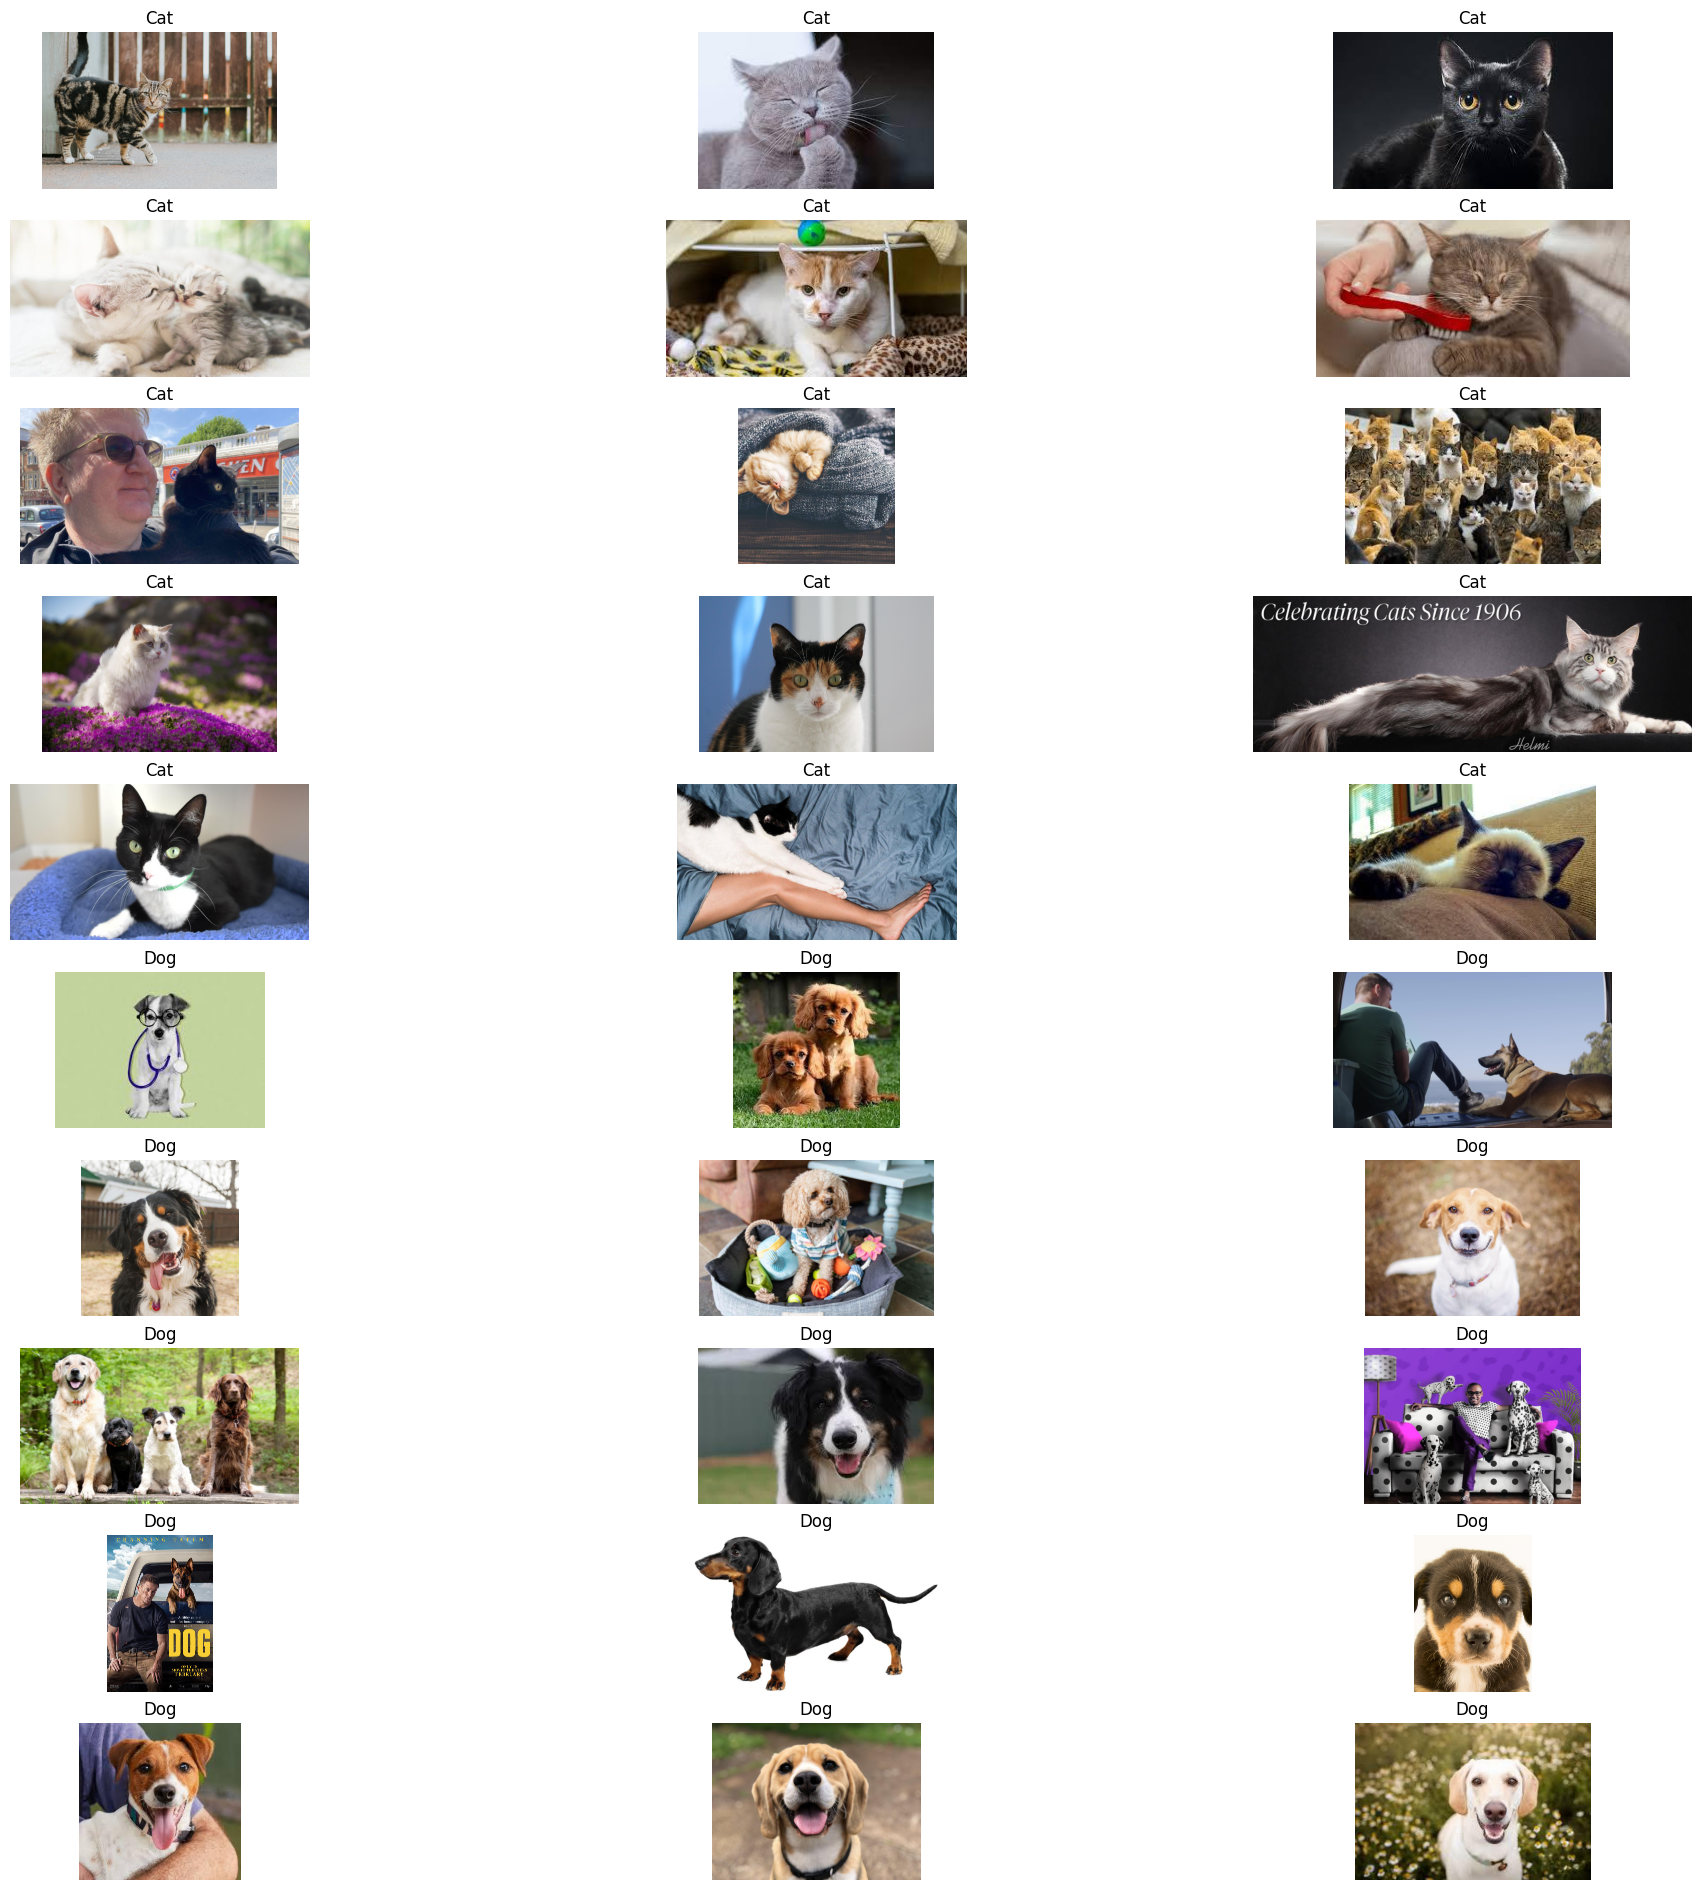

In [15]:
show_images(examples)

Можно увидеть, что в нашем тренировочном наборе много разноплановых картинок с котами и собаками. В наборе есть не только фотографии, но и картинки животных. В наборе также большое количество вариций картинок и фотографий, что требует достаточно сложную нейронную модель для нашего классификации

In [16]:
test_examples = get_examples_data(test_data.imgs,30)

## Тестовая выборка

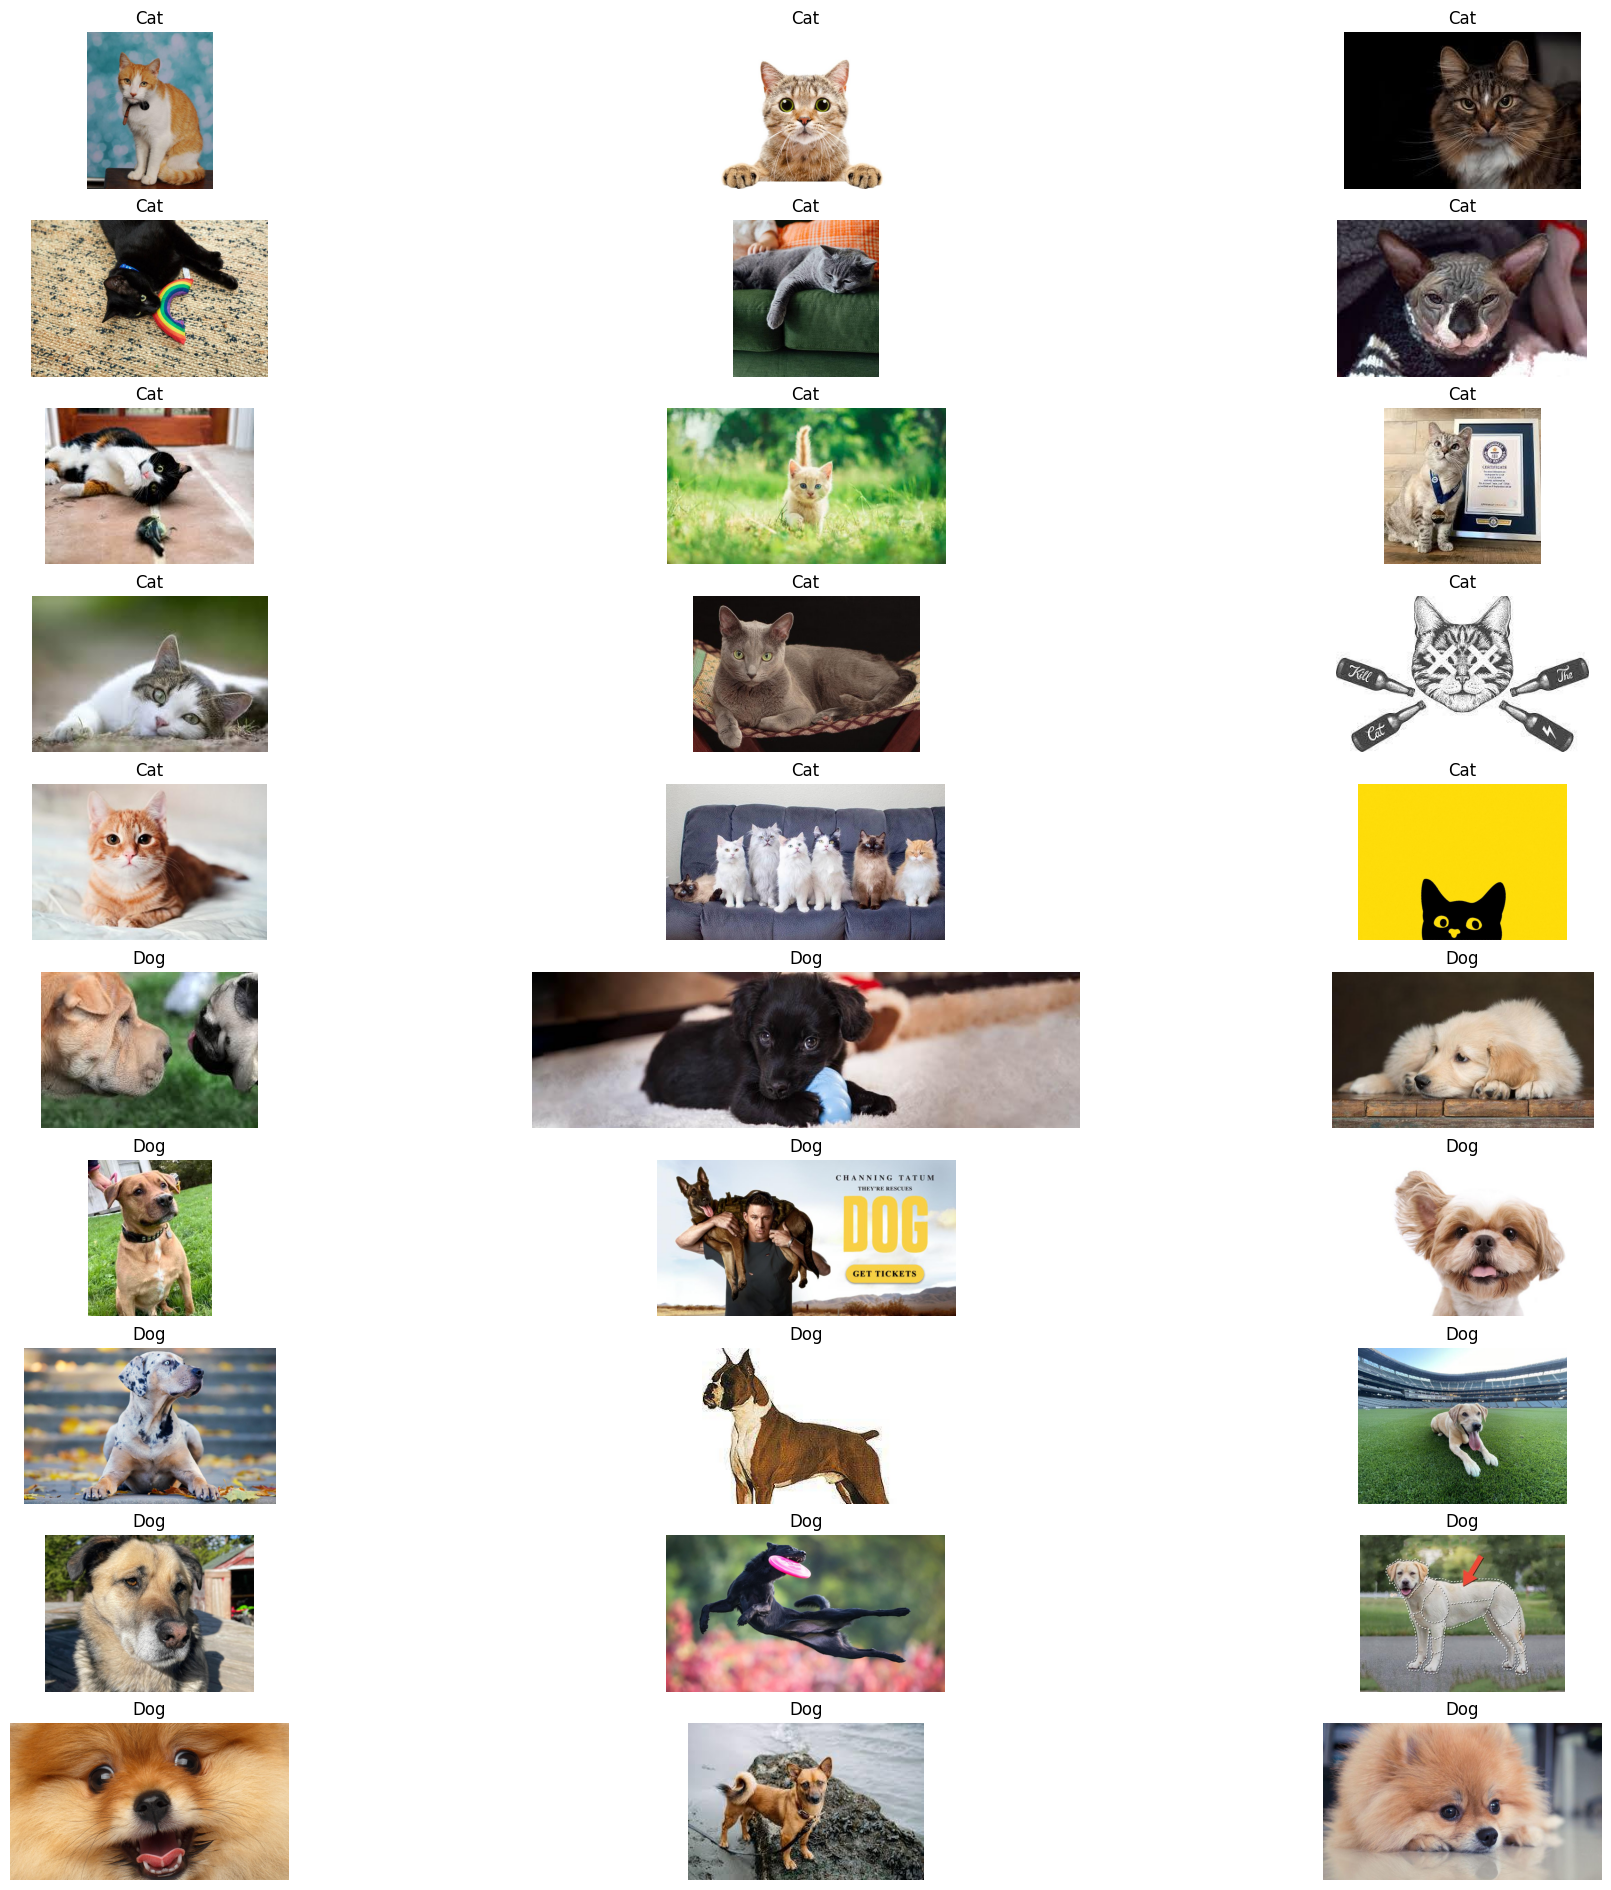

In [17]:
show_images(test_examples)

Видно что в тестовой выборке также есть большое кол-во разноплановых картинок. Видно что картинки похожи на то, что есть в обучающем наборе. Значит нету риска того, что наша модель не сможет классифицировать картинки из тестового набора

## Модель

### Для распознования объектов по изображениям будем использовать сверточные нейронные сети, которые отлично подходят для такого рода задач  
Класс сверточной сети. В данной модели используются сверточные слои, хорошо работающие с задачами по изображению. Есть полносвязные слои для  самой классификации картинок. Также есть слой dropout, необходимый для предотвращения переобучения модели

In [179]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5,padding=1,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=5,padding=1,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        
         
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        
        self.fc1 = nn.Linear(2304,512)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out =self.layer1(x)
        out =self.layer2(out)
        out =self.layer3(out)
        out =out.view(out.size(0),-1)
        out = self.dropout(out)
        out =self.relu(self.fc1(out))
        out =self.relu(self.fc2(out))
        return self.fc3(out)

Функция ошибки - крос энтропия, подходящая задач для классификации

In [180]:
model = Conv()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Обучим на нашу нейронную сеть

In [181]:
total_step = len(train_data_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    epoch_acc = 0
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_data_loader):
        outputs = model(images)
        
        
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        correct= (outputs.argmax(dim=1)==labels).float().mean()
        
        epoch_acc += correct/len(train_data_loader)
        epoch_loss += loss/len(train_data_loader)
        
        acc_list.append(correct)
        
    
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}'
            .format(epoch + 1, num_epochs,epoch_loss,epoch_acc))
    if epoch_loss <= 0.005 and epoch > 3:
        break

Epoch [1/20], Loss: 0.6976, Accuracy: 0.57
Epoch [2/20], Loss: 0.6378, Accuracy: 0.63
Epoch [3/20], Loss: 0.5930, Accuracy: 0.67
Epoch [4/20], Loss: 0.4911, Accuracy: 0.78
Epoch [5/20], Loss: 0.4372, Accuracy: 0.81
Epoch [6/20], Loss: 0.3765, Accuracy: 0.84
Epoch [7/20], Loss: 0.2591, Accuracy: 0.89
Epoch [8/20], Loss: 0.2291, Accuracy: 0.91
Epoch [9/20], Loss: 0.1557, Accuracy: 0.95
Epoch [10/20], Loss: 0.0943, Accuracy: 0.97
Epoch [11/20], Loss: 0.1064, Accuracy: 0.96
Epoch [12/20], Loss: 0.0796, Accuracy: 0.97
Epoch [13/20], Loss: 0.1097, Accuracy: 0.95
Epoch [14/20], Loss: 0.0365, Accuracy: 0.99
Epoch [15/20], Loss: 0.0196, Accuracy: 0.99
Epoch [16/20], Loss: 0.0165, Accuracy: 0.99
Epoch [17/20], Loss: 0.0199, Accuracy: 0.99
Epoch [18/20], Loss: 0.0191, Accuracy: 0.99
Epoch [19/20], Loss: 0.0149, Accuracy: 0.99
Epoch [20/20], Loss: 0.0089, Accuracy: 1.00


В рамках обучающего набора наша нейронка работает хорошо 

## Проверим корректность нашей модели на тренировочном наборе

In [242]:
model.eval()
all_labels = []
all_predicted = []
all_images = []
with torch.no_grad():
    acc = 0
    total = 0
    for images, labels in test_data_loader:
        outputs = model(images)
        total += labels.size(0)
        correct = (outputs.argmax(dim=1)==labels).float().mean()
        if len(all_labels) == 0:
            all_images = images
            all_labels = labels
            all_predicted = outputs.argmax(dim=1)

        acc += correct/len(test_data_loader)

    print('Test Accuracy of the model on the {} test images: {}'.format(total ,acc))


Test Accuracy of the model on the 140 test images: 0.7124999761581421


На тестовом наборе модель работает хуже. Если сравнить кач-во на обуч. наборе и на тестовом наборе. Можно сделать вывод о переобучении модели. Однако 71 процент тоже неплохо и можно выбрать другую архитектуру для нашей модели

## Посмотрим насколько правильно наша модель работает на тестовой выборке

In [235]:
def compare_model(images_data,predicted_labels,labels):
    size = len(images_data)
    fig, axs = plt.subplots(int(np.ceil(size/3)), 3,figsize=(24,24))
    fig.tight_layout(pad=5.0)
    axs = axs.flatten()
    for image,ax,label,predict in zip(images_data,axs,labels,predicted_labels):
        image = image.permute(1, 2, 0)
        ax.imshow(image)
        ax.title.set_text(f'True label: {display_label(label)}\n Predicted label: {display_label(predict)}')
        ax.set_axis_off()
    for ax in axs[size:]:
        ax.remove()
    plt.show()

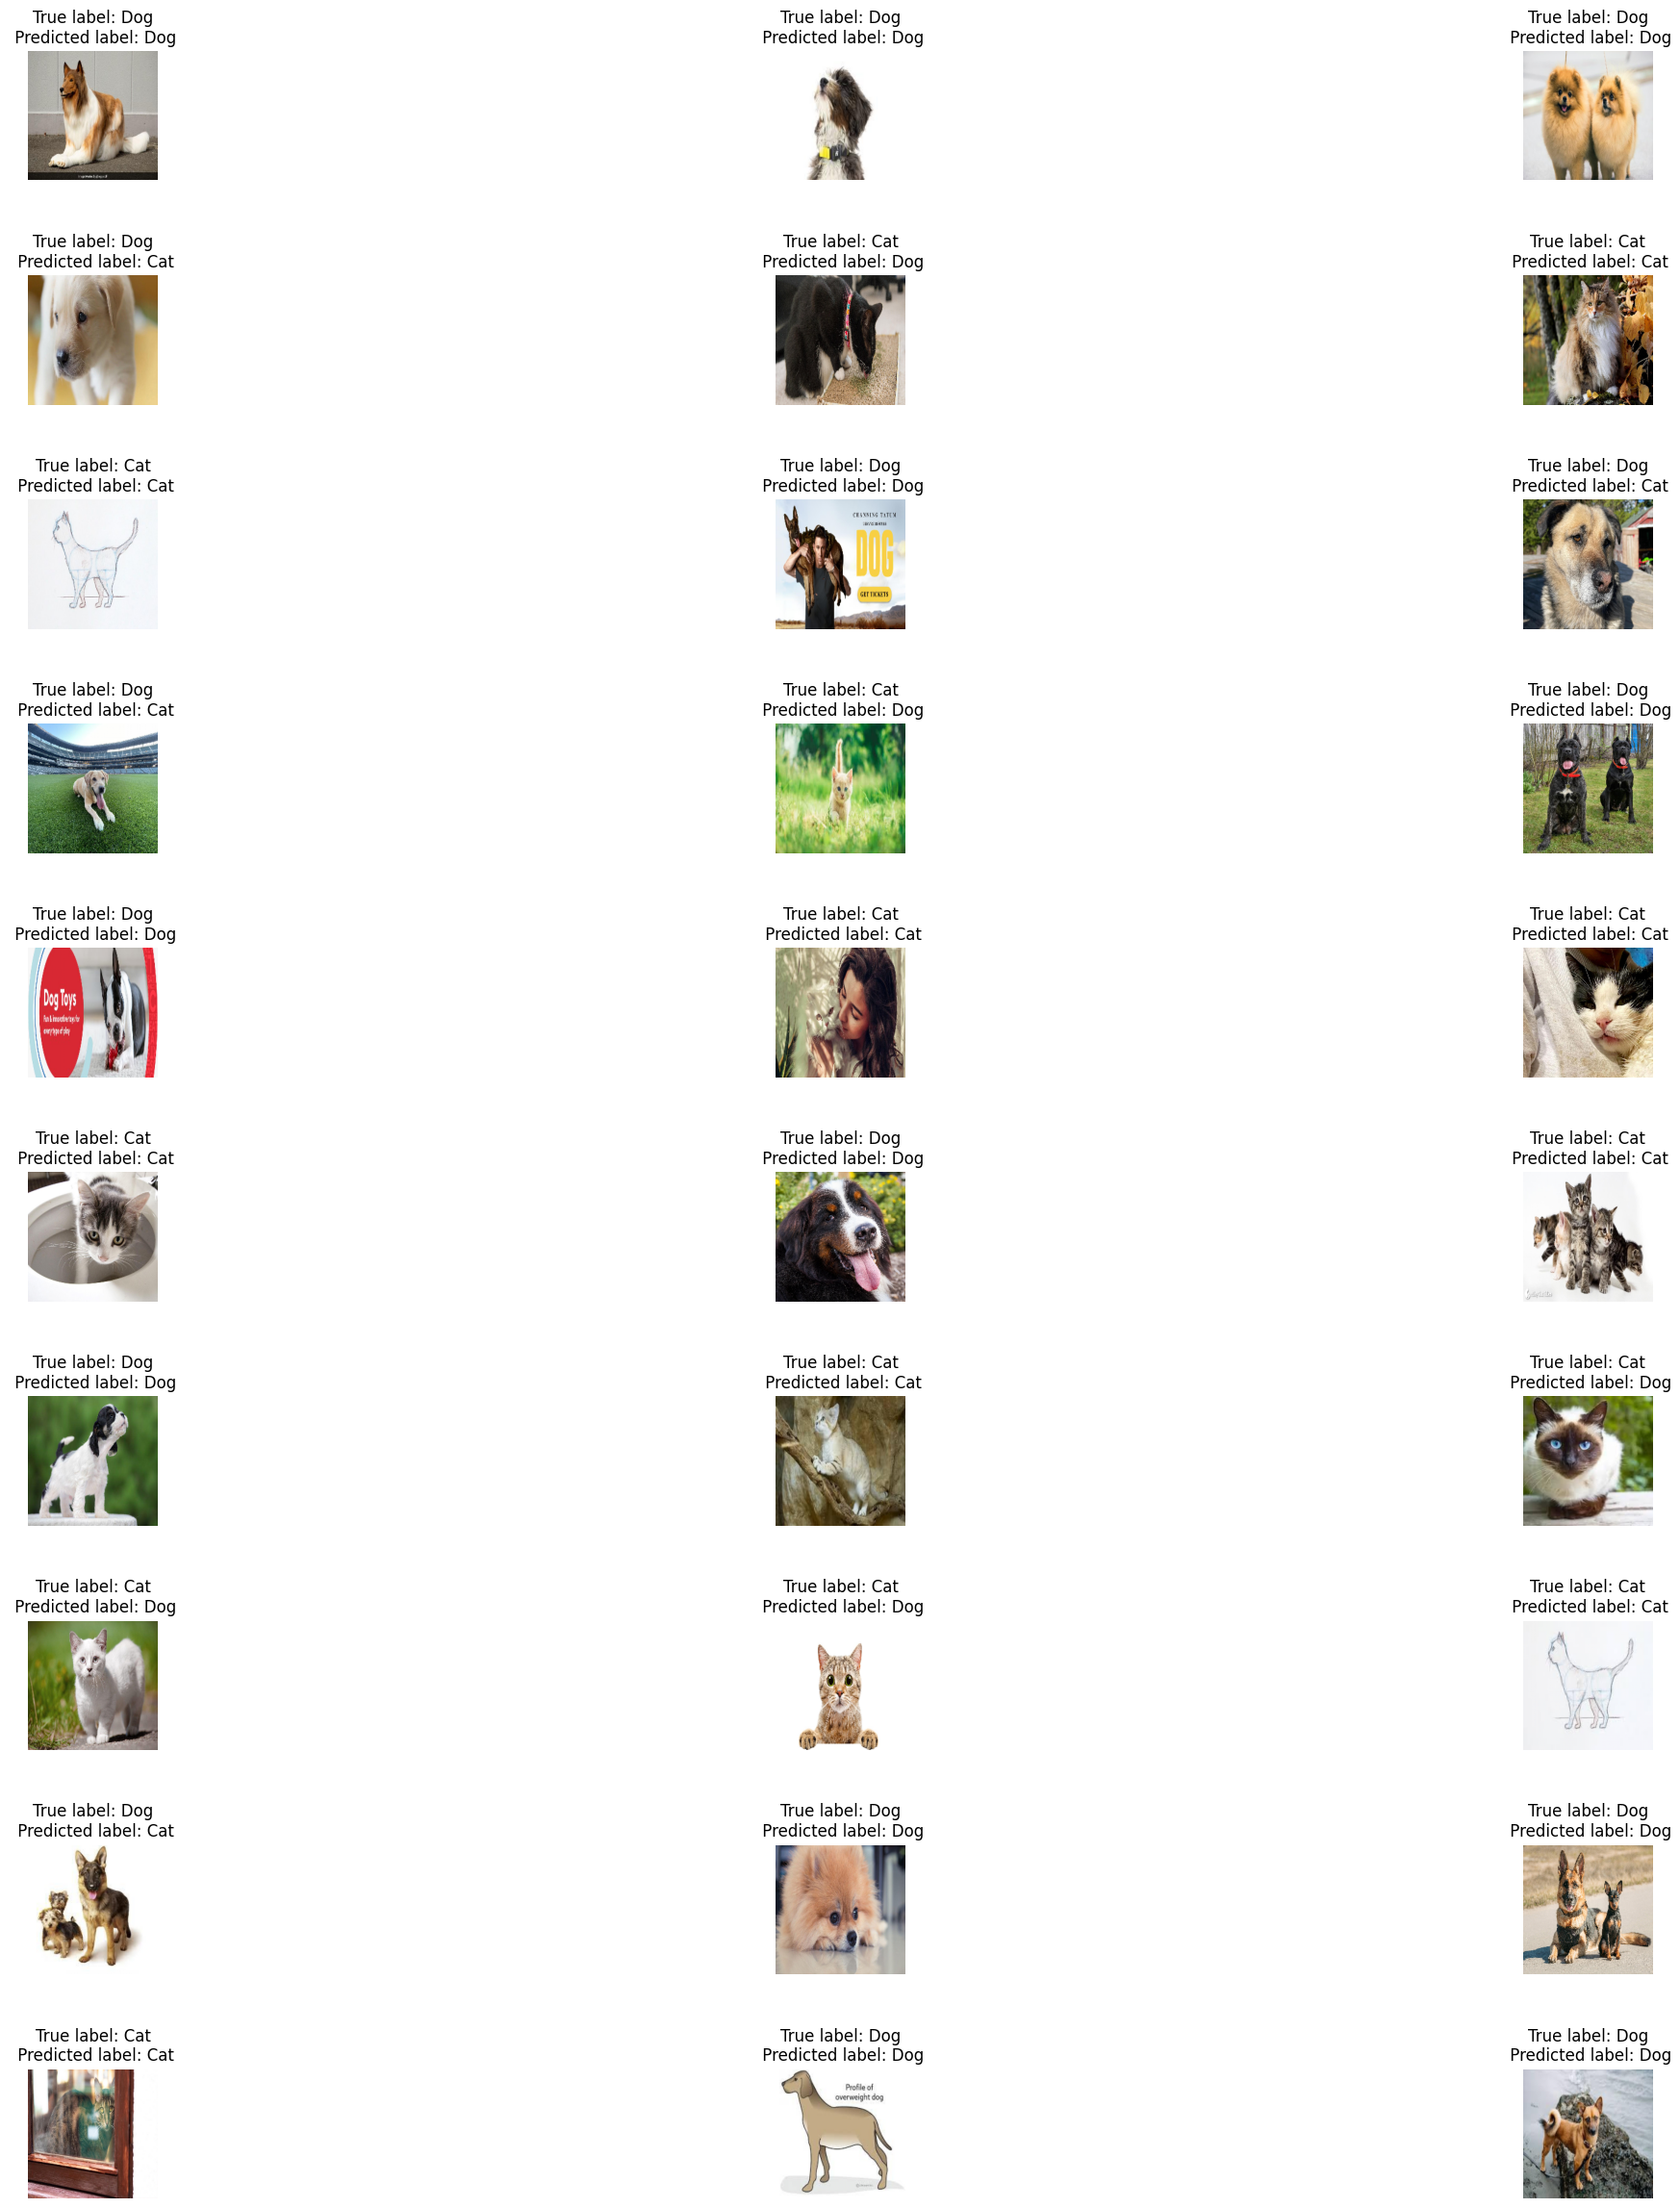

In [237]:
compare_model(all_images[:30],all_predicted[:30],all_labels[:30])

### Нарисуем график, на котором увидим как меняется точность и ошибка в каждой эпохе
Видно как меняется ошибка и точность нашей модели с течением времени

In [199]:
def display_learning_plot(title,acc_list,loss_list):
    plt.title(title)
    plt.grid()
    plt.ylim([0,1.5])
    plt.plot(acc_list,'y',label='acc')
    plt.plot(loss_list,'r',label='loss')
    plt.legend()
    plt.xticks([])
    plt.show()

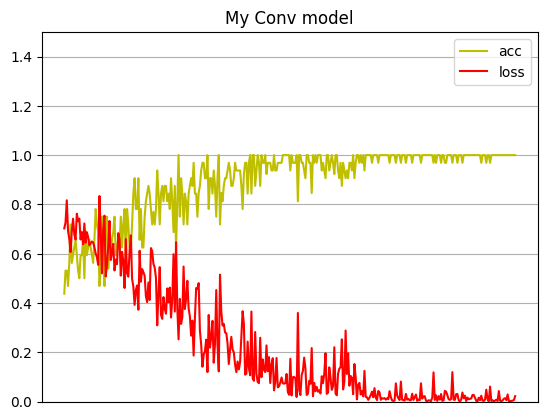

In [200]:
display_learning_plot('My Conv model',acc_list,loss_list)

## Модель №2 
В качестве второй модели я выбрал уже готовую нейронную модель для работы с изображением, Xception. Данная модель хорошо себя показывает в таких родах задач. Единственное мы добавим несколько слоев для того, чтоб эта модель справилась с нашей задач

In [153]:
import timm

xceptin_model = timm.create_model(model_name="xception", pretrained=True)

for param in xceptin_model.parameters():
    param.requere_grad = False

In [154]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [155]:
advanced_xception = nn.Sequential(
    xceptin_model,
    nn.ReLU(),
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
)
advanced_xception
num_epochs = 10
learning_rate = 0.0001

In [156]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(advanced_xception.parameters(), lr=learning_rate)


In [158]:
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    epoch_acc = 0
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_data_loader):
        outputs = advanced_xception(images)
        
        
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct= (outputs.argmax(dim=1)==labels).float().mean()
        
        epoch_acc += correct/len(train_data_loader)
        epoch_loss += loss/len(train_data_loader)
        
        acc_list.append(correct)
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}'.format(epoch + 1, num_epochs,epoch_loss,epoch_acc))
    if epoch_loss <= 0.005 and epoch > 3:
        break

D:\PythonProjects\PythonIntepret\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/10], Loss: 0.0121, Accuracy: 1.00
Epoch [2/10], Loss: 0.0188, Accuracy: 1.00
Epoch [3/10], Loss: 0.0047, Accuracy: 1.00
Epoch [4/10], Loss: 0.0070, Accuracy: 0.99
Epoch [5/10], Loss: 0.0105, Accuracy: 1.00
Epoch [6/10], Loss: 0.0017, Accuracy: 1.00


Уже видно, что модель быстро обучилась на обучающем наборе

In [238]:
advanced_xception.eval()
all_labels = []
all_predicted = []
all_images = []
with torch.no_grad():
    acc = 0
    total = 0
    for images, labels in test_data_loader:
        outputs = advanced_xception(images)
        total += labels.size(0)
        if len(all_labels) == 0:
            all_images = images
            all_labels = labels
            all_predicted = outputs.argmax(dim=1)
        correct = (outputs.argmax(dim=1)==labels).float().mean()
        acc += correct/len(test_data_loader)

    print('Test Accuracy of the model on the {} test images: {}'.format(total ,acc))

Test Accuracy of the model on the 140 test images: 0.9625000357627869


Отлично показывает на тестовом наборе

In [226]:
def predict(model,image):
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image)
    image = image[None, :]
    pred = model(image)
    prob = F.softmax(pred[0], dim=-1).tolist()
    
    return ('Cat', prob) if pred.argmax() == 0 else ('Dog', prob)

In [227]:
image = plt.imread('C:/Users/Lenovo/CatsAndDogs/test/cats/cat_355.jpg')
predict(advanced_xception,image)

('Cat', [0.7757517099380493, 0.22424829006195068])

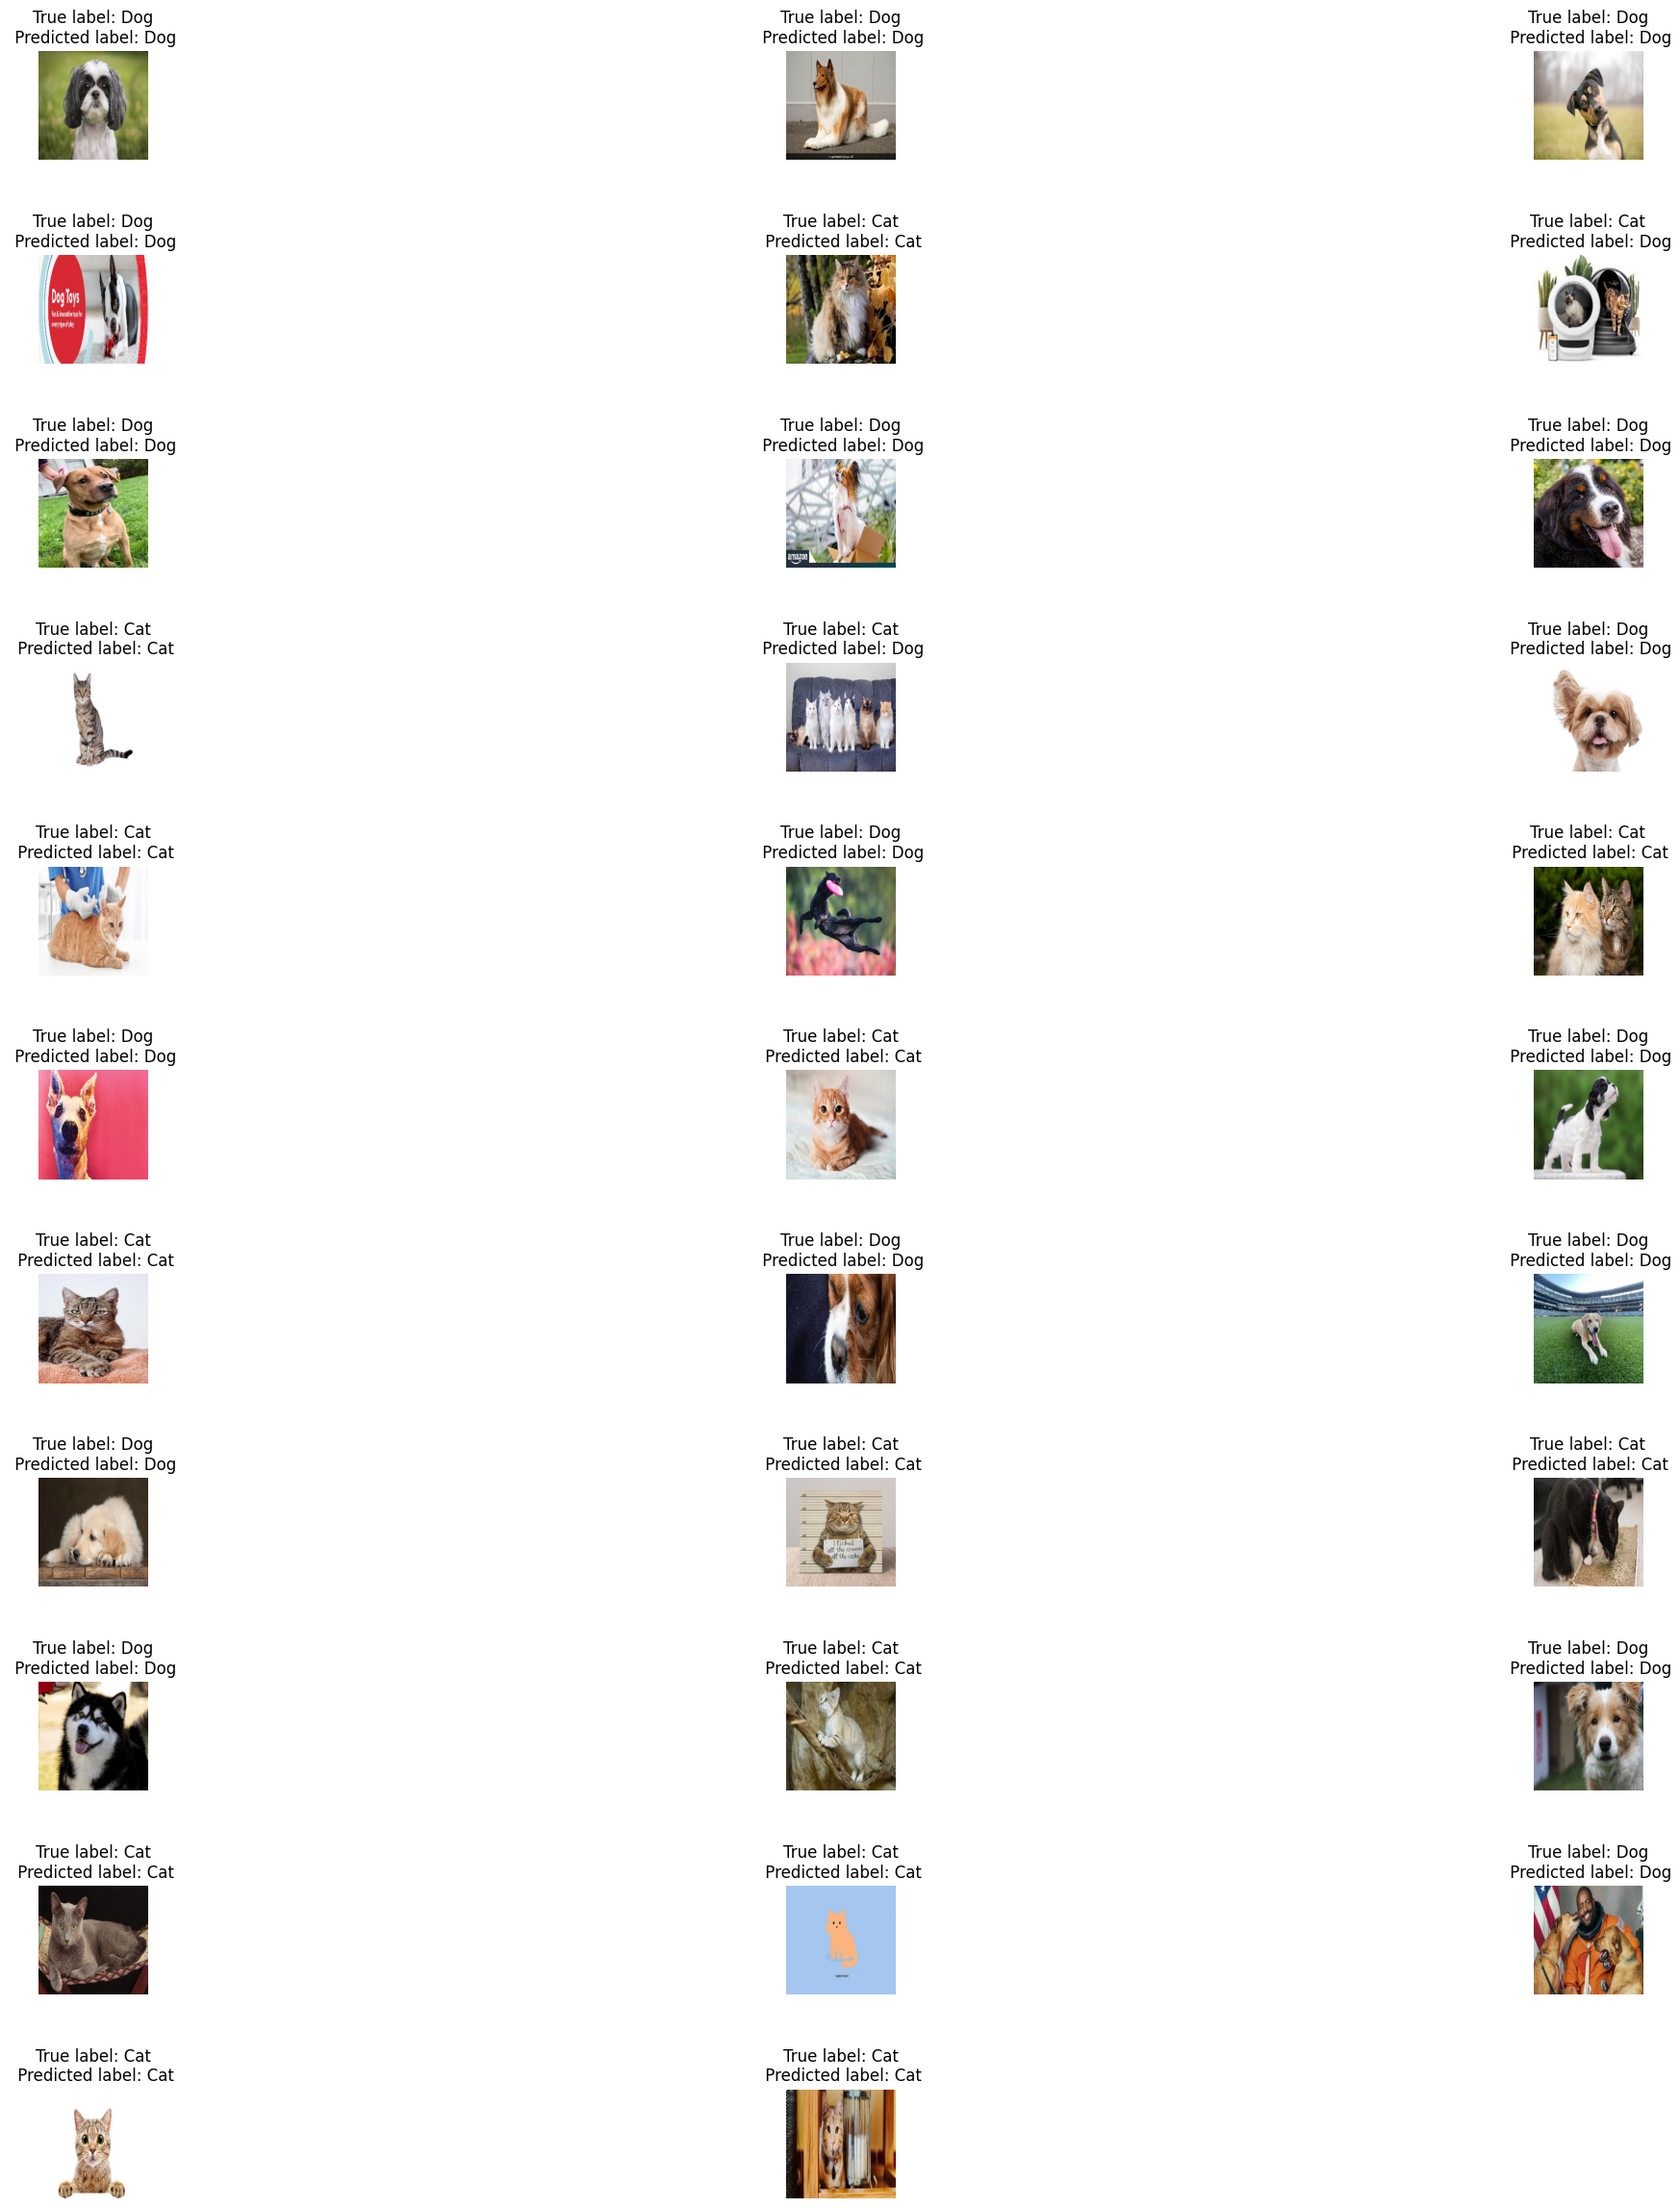

In [239]:
compare_model(all_images,all_predicted,all_labels)

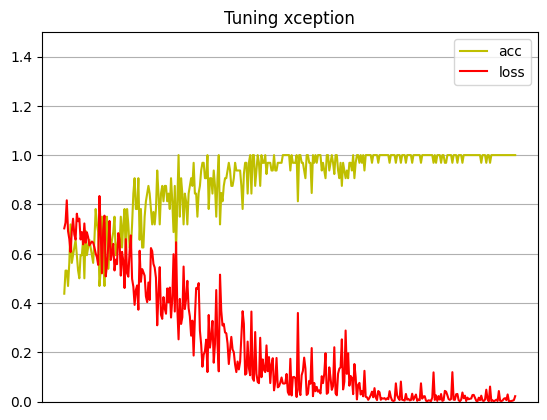

In [240]:
display_learning_plot('Tuning xception',acc_list,loss_list)